# Productionazing Machine Learning with Vertex AI

### Set up project ID

In [246]:
import os

PROJECT_ID = "crazy-hippo-01"

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  crazy-hippo-01


### Define Current Timestamp

In [247]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
print('Timestamp: ', TIMESTAMP)

Timestamp:  20210602062530


### Create storage bucket

In [3]:
BUCKET_NAME = "gs://crazy-vertex-ai-pipelines"
REGION = "us-central1" 
ML_PROJECT_NAME = "earnings_classifier"
USER = "crazy-hippo" 

If you need to create the Bucket

In [35]:
! gsutil mb -l $REGION $BUCKET_NAME

Creating gs://crazy-vertex-ai-pipelines/...


In [59]:
! gsutil ls -al $BUCKET_NAME

### Import Libraries and define constants

In [248]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

PIPELINE_ROOT = "{}/{}/{}".format(BUCKET_NAME, ML_PROJECT_NAME, USER)

PIPELINE_ROOT

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin


'gs://crazy-vertex-ai-pipelines/earnings_classifier/crazy-hippo'

In [319]:
import json
from typing import NamedTuple

from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import component
from kfp.v2.google.client import AIPlatformClient

from kfp.v2.dsl import (
    Input,
    Output,
    Artifact,
    Model,
    Dataset,
    Metrics,
    InputPath
)

### Define Pipeline Comnponents

#### Pipeline Step 1 - Extract Data

In [289]:
@component(output_component_file='read_transform_data.yaml',
          base_image='python:3.9',
          packages_to_install=['pandas', 
                             'google-cloud-bigquery', 
                             'pyarrow' , 
                             'gcsfs',
                             'numpy'
                              ])
def extract_data(
        INPUT_DATA : str,
        DATASET_VERSION : int,
        DATASET : Output[Dataset],
        pipeline_metrics: Output[Metrics]) -> NamedTuple(
          'ComponentOutputs',
          [
              ('dataset_name', str),
              ('dataset_version', int),
              ('num_of_examples', int),
              ('categorical_col', int),
              ('numeric_col', int)
          ]
    ):
    
    #Import libraries
    import pandas as pd
    import time
    import numpy
    from google.cloud.bigquery import Client, QueryJobConfig
    
    
    #Initiate BigQuery Client
    client = Client(project='crazy-hippo-01')
    
    query = """SELECT age, workclass, occupation, education_num, marital_status, capital_gain, income_bracket
    FROM `crazy-hippo-01.census_data_us.census_raw` 
    LIMIT 20000
    """
    
    #Run Query
    job = client.query(query)
    df = job.to_dataframe()
    
    #Set and calculate Dataset Metadata
    dataset_name = INPUT_DATA
    dataset_version = DATASET_VERSION
    num_of_examples = len(df)
    
    #Data Types
    categorical_col = 0
    numeric_col = 0
    for col in df.columns : 
        print(type(df[col][0]))
        if type(df[col][0]) == str :  
            categorical_col += 1
        elif type(df[col][0]) == numpy.int64 :
            numeric_col += 1
    
    #Write data to GCS 
    df.to_csv(DATASET.path, index=False, header=True)
    
    # Log Metrics
    pipeline_metrics.log_metric('dataset_name', dataset_name)
    pipeline_metrics.log_metric('dataset_version', dataset_version)
    pipeline_metrics.log_metric('num_of_examples', num_of_examples)
    pipeline_metrics.log_metric('categorical_col', categorical_col)
    pipeline_metrics.log_metric('numeric_col', numeric_col)
    
    


    from collections import namedtuple
    
    component_outputs = namedtuple('ComponentOutputs',
        ['dataset_name', 
         'dataset_version', 
         'num_of_examples', 
         'categorical_col', 
         'numeric_col'])
        
    return component_outputs(dataset_name, 
                             dataset_version, 
                             num_of_examples, 
                             categorical_col, 
                             numeric_col)
    

#### Pipeline Step 2 - Transform and Prepare Data

In [290]:
@component(output_component_file='read_transform_data.yaml',
          base_image='python:3.9',
          packages_to_install=['pandas', 
                             'google-cloud-bigquery', 
                             'pyarrow' , 
                             'gcsfs', 
                             'sklearn'])
def read_transform_data(
        DATASET : Input[Dataset],
        TRAINING_DATA : Output[Dataset],
        TEST_DATA : Output[Dataset],
        VALIDATION_DATA : Output[Dataset]
    ):
    
    #Import libraries
    import pandas as pd
    import time
    from sklearn.model_selection import train_test_split
    from google.cloud.bigquery import Client, QueryJobConfig
    
    df = pd.read_csv(DATASET.path)
    
    #Drop null values in dataset
    df = df.dropna()
    
    #Create training, test and validation datasets
    train, test = train_test_split(df, test_size=0.20, random_state=42)
    train, val = train_test_split(train, test_size=0.20, random_state=42)

    #Define Staging Bucket in GCS
    #BUCKET = 'gcs://crazy-hippo-01/kubeflow_staging/earnings_model/'
    #TRAINING_PATH = BUCKET + 'datasets/training/training{}'.format(str(int(time.time())))  + '.csv'
    #TEST_PATH = BUCKET + 'datasets/testing/test{}'.format(str(int(time.time())))  + '.csv'
    #VALIDATION_PATH = BUCKET + 'datasets/validation/validation{}'.format(str(int(time.time())))  + '.csv'
    
    #Define Datasets Names
    #TRAINING_DATA.uri = TRAINING_PATH
    #TEST_DATA.uri = TEST_PATH
    #VALIDATION_DATA.uri = VALIDATION_PATH
    
    print(TRAINING_DATA.path)
    print(TEST_DATA.path)
    print(VALIDATION_DATA.path)

    #Write data to GCS Storage
    train.to_csv(TRAINING_DATA.path, index=False, header=True)
    test.to_csv(TEST_DATA.path, index=False, header=True)
    val.to_csv(VALIDATION_DATA.path, index=False, header=True)

    #Define outputs with namedtuple
    #from collections import namedtuple
    
    #return_values = namedtuple(
    #  'ComponentOutputs',
    #    ['training_data', 'test_data', 'validation_data'])
        
    #return TRAINING_DATA, TEST_DATA), VALIDATION_DATA


#### Pipeline Step 3 - Train and Save Model

In [291]:
@component(output_component_file='train_model.yaml',
          base_image='python:3.9',
          packages_to_install=['pandas', 
                             'pyarrow' , 
                             'gcsfs' , 
                             'google-cloud-bigquery-storage',
                             'tensorflow'])
def train_model(TRAINING_DATA: Input[Dataset], 
                TEST_DATA: Input[Dataset], 
                VALIDATION_DATA: Input[Dataset],
                MODEL: Output[Model]
               ):
    
    
    import pandas as pd
    import time
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.layers.experimental import preprocessing
    
    #VARIABLES AND TRAINING PARAMETERS
    TRAIN_DATA = pd.read_csv(TRAINING_DATA.path)
    TEST_DATA = pd.read_csv(TEST_DATA.path)
    VAL_DATA = pd.read_csv(VALIDATION_DATA.path)
    
    BATCH_SIZE = 32
    
    print(tf.__version__)
    
    print(MODEL.path)

    #TENSORFLOW DATASET FUNCTION
    def helperfunc_create_dataset(dataframe, shuffle=True, batch_size=5):
        dataframe = dataframe.copy()
        labels = dataframe.pop('income_bracket')
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        ds = ds.prefetch(batch_size)
        return ds
    
    #NORMALIZATION FUNCTION
    def helperfunc_get_normalization_layer(name, dataset):
        # Create a Normalization layer for our feature.
        normalizer = preprocessing.Normalization()

        # Prepare a Dataset that only yields our feature.
        feature_ds = dataset.map(lambda x, y: x[name])

        # Learn the statistics of the data.
        normalizer.adapt(feature_ds)

        return normalizer
    
    #CATEGORY ENCODING FUNCTION
    def helperfunc_get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
        # Create a StringLookup layer which will turn strings into integer indices
        if dtype == 'string':
            index = preprocessing.StringLookup(max_tokens=max_tokens)
        else:
            index = preprocessing.IntegerLookup(max_values=max_tokens)

        # Prepare a Dataset that only yields our feature
        feature_ds = dataset.map(lambda x, y: x[name])

        # Learn the set of possible values and assign them a fixed integer index.
        index.adapt(feature_ds)

        # Create a Discretization for our integer indices.
        encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

        # Prepare a Dataset that only yields our feature.
        feature_ds = feature_ds.map(index)

        # Learn the space of possible indices.
        encoder.adapt(feature_ds)

        # Apply one-hot encoding to our indices. The lambda function captures the
        # layer so we can use them, or include them in the functional model later.
        return lambda feature: encoder(index(feature))
    
    #CREATE TENSORFLOW DATASETS
    TRAIN_DS = helperfunc_create_dataset(TRAIN_DATA, batch_size=BATCH_SIZE)
    VALIDATION_DS = helperfunc_create_dataset(VAL_DATA, shuffle=False, batch_size=BATCH_SIZE)
    TESTING_DS = helperfunc_create_dataset(TEST_DATA, shuffle=False, batch_size=BATCH_SIZE)
    
    #CREATE PREPROCESSING LAYERS
    ALL_INPUTS = []
    ENCODED_FEATURES = []

    NUMERICAL = ['age' , 'capital_gain']
    CATEGORICAL_INT_COLS = ['education_num']
    CATEGORICAL_STRING_COLS = ['occupation', 
                               'workclass', 
                               'marital_status']
    TARGET = ['income_bracket']
    
    # Numeric features.
    for header in NUMERICAL:
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = helperfunc_get_normalization_layer(header, TRAIN_DS)
        encoded_numeric_col = normalization_layer(numeric_col)
        ALL_INPUTS.append(numeric_col)
        ENCODED_FEATURES.append(encoded_numeric_col)
        
    # Categorical features encoded as integers.
    for header in CATEGORICAL_INT_COLS:
        categorical_int_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoding_layer = helperfunc_get_category_encoding_layer(header, TRAIN_DS, dtype='int64', max_tokens=5)
        encoded_categorical_int_col = encoding_layer(categorical_int_col)
        ALL_INPUTS.append(categorical_int_col)
        ENCODED_FEATURES.append(encoded_categorical_int_col)
    
    # Categorical features encoded as string.
    for header in CATEGORICAL_STRING_COLS:
        categorical_string_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
        encoding_layer = helperfunc_get_category_encoding_layer(header, TRAIN_DS, dtype='string', max_tokens=5)
        encoded_categorical_string_col = encoding_layer(categorical_string_col)
        ALL_INPUTS.append(categorical_string_col)
        ENCODED_FEATURES.append(encoded_categorical_string_col)
    
        
    #CREATE and COMPILE MODEL
    all_features = tf.keras.layers.concatenate(ENCODED_FEATURES)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(ALL_INPUTS, output)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    
    #TRAIN MODEL
    history = model.fit(TRAIN_DS, epochs=10, validation_data=VALIDATION_DS)
    
    
    #Define Bucket in GCS for Model Storage
    BUCKET = 'gs://crazy-hippo-01/kubeflow_staging/earnings_model/models/'
    
    #Define MODEL PATH 
    MODEL_PATH = BUCKET + 'earnings_model{}'.format(str(int(time.time())))
    
    MODEL.uri = MODEL_PATH 
    
    
    #Save model to Artifact Store for Project
    model.save(MODEL.path)
    
    print('Model saved to: ' + MODEL.path)

    


#### Pipeline Step 4 - Evaluate Saved Model

In [293]:
@component(output_component_file='evaluate_model.yaml',
          base_image='python:3.9',
          packages_to_install=['pandas',
                         'google-cloud-bigquery',
                         'pyarrow', 
                         'gcsfs',
                         'tensorflow',
                         'google-cloud-aiplatform'])
def evaluate_validate_model(
                            MODEL : Input[Model], 
                            TEST_DATA: Input[Dataset], 
                            num_of_examples: int,
                            categorical_col: int,
                            numeric_col: int,
                            pipeline:str, 
                            framework:str,
                            input_path:str,
                            dataset_version:int,
                            pipeline_metrics: Output[Metrics]) -> NamedTuple(
      'ComponentOutputs',
      [
          ('accuracy', float),
          ('loss', float),
      ]):
    
    import pandas as pd
    import tensorflow as tf
    from tensorflow import keras
    
    #HELPER FUNCTION - TENSORFLOW DATASET FUNCTION
    def helperfunc_create_dataset(dataframe, shuffle=True, batch_size=5):
        dataframe = dataframe.copy()
        labels = dataframe.pop('income_bracket')
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        ds = ds.prefetch(batch_size)
        return ds
    
    #LOAD TRAINED MODEL FROM ARTIFACT STORE
    reloaded_model = tf.keras.models.load_model(MODEL.path)
    
    #READ TESTING DATASET
    TESTING_DATA = pd.read_csv(TEST_DATA.path)

    #SET BATCG SIZE
    BATCH_SIZE = 32
    
    #CALL HELPER FUNCTION TO CREATE TENSORFLOW DATASET
    TESTING_DS = helperfunc_create_dataset(TESTING_DATA, shuffle=False, batch_size=BATCH_SIZE)
    
    #EVALUATE MODEL WITH TEST DATA
    loss, accuracy = reloaded_model.evaluate(TESTING_DS)
    
    accuracy = float(accuracy)
    loss = float(loss)
    
    #PRINT ACCURACY METRIC
    print("Accuracy", accuracy)
    print("Loss", loss)
    
    
    from tensorflow.python.lib.io import file_io    
    
    #Write Metrics to BigQuery Table for Validation and possible promotion to Deployment
    from google.cloud.bigquery import Client, QueryJobConfig
    
    #Initiate BigQuery Client
    client = Client(project='crazy-hippo-01')
    
    print('Sending Metrics into BigQuery')
    
    #Define DML Query to Insert Metrics into BugQuery
    query = """INSERT `crazy-hippo-01.census_data_us.model_metrics_history` (model_name, pipeline, framework, accuracy, loss)
    VALUES ("{}", "{}", "{}", {}, {})  
    """.format(MODEL.path, pipeline, framework, accuracy, loss)
    
    #Run Query
    job = client.query(query)
    
    print('Metrics sent to BigQuery!')
    
    # Export two metrics
    pipeline_metrics.log_metric('accuracy', accuracy)
    pipeline_metrics.log_metric('loss', loss)

    from collections import namedtuple
    
    component_outputs = namedtuple('ComponentOutputs',
        ['accuracy', 'loss'])
    
    
    from datetime import datetime
    
    TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
    MY_PROJECT = 'crazy-hippo-01'
    REGION = 'us-central1'
    EXPERIMENT_NAME = 'earnings-classifier-ver1'
    RUN_NAME = "tensorflow-dl-model-" + TIMESTAMP
    
    
    #Store Experiment Metrics in Vertex AI
    from google.cloud import aiplatform

    aiplatform.init(project=MY_PROJECT, location=REGION, experiment=EXPERIMENT_NAME)
    aiplatform.start_run(run=RUN_NAME)
    
    PARAMETERS = {
        #"Model" : MODEL,
        #"Pipeline" : pipeline,
        #"Dataset" : input_path,
        "Dataset Version" : dataset_version
    }
    
    aiplatform.log_params(PARAMETERS)
    
    METRICS = {
        'Num_of_examples': num_of_examples,
        'Categorical_col': categorical_col,
        'Numeric_col': numeric_col,
        "Accuracy": accuracy, 
        "Loss": loss
    }
    
    aiplatform.log_metrics(METRICS)
    
    from collections import namedtuple
    
    component_outputs = namedtuple('ComponentOutputs', 
                                   ['accuracy', 'loss'])
    
        
    return component_outputs(accuracy, loss)

### Define Pipeline

In [294]:
@dsl.pipeline(
  name='binaryclassmodel6',
  description='Binary Classification Model with Tensorflow Deep Learning and Connected Pre-processing Layers'
)
def binary_classifier_earnings_v6(
    pipeline: str = 'Tensorflow DL Version 6',
    framework: str = 'Tensorflow',
    input_path: str = 'crazy-hippo-01.census_data_us.census_raw',
    dataset_version: int = 3
    ):
    
    first_step = extract_data(input_path,
                              dataset_version)
   
    second_step = read_transform_data(first_step.outputs['DATASET'])
    #first_step.execution_options.caching_strategy.max_cache_staleness = "P0D"

   
    third_step = train_model(second_step.outputs['TRAINING_DATA'], 
                             second_step.outputs['TEST_DATA'], 
                             second_step.outputs['VALIDATION_DATA'])
    #second_step.execution_options.caching_strategy.max_cache_staleness = "P0D"
    

    fourth_step = evaluate_validate_model(third_step.outputs['MODEL'], 
                                          second_step.outputs['TEST_DATA'],
                                          first_step.outputs['num_of_examples'],
                                          first_step.outputs['categorical_col'],
                                          first_step.outputs['numeric_col'],
                                          pipeline, 
                                          framework, 
                                          input_path, 
                                          dataset_version)
    #third_step.execution_options.caching_strategy.max_cache_staleness = "P0D"

### Compile and run Pipeline

Compile pipeline

In [295]:
from kfp.v2 import compiler  

compiler.Compiler().compile(
    pipeline_func=binary_classifier_earnings_v6, package_path="earnings_pipeline_ver6.json"
)

Instantiate the API client object

In [296]:
from kfp.v2.google.client import AIPlatformClient  # noqa: F811

api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

Run pipeline

In [297]:
SERVICE_ACCOUNT = 'pipelines-vertex-ai@crazy-hippo-01.iam.gserviceaccount.com'

In [298]:
response = api_client.create_run_from_job_spec(
    job_spec_path="earnings_pipeline_ver6.json",
    pipeline_root=PIPELINE_ROOT,
    service_account=SERVICE_ACCOUNT 
)

Alternate Test SA

In [169]:
SERVICE_ACCOUNT = 'edit-rights@crazy-hippo-01.iam.gserviceaccount.com'

#### Looking at Experiment Metrics and Metadata

In [299]:
from google.cloud import aiplatform
aiplatform.init(project='crazy-hippo-01', 
                location=REGION, 
                experiment='earnings-classifier-ver1')

experiment_df = aiplatform.get_experiment_df()
experiment_df

,experiment_name,run_name,param.Dataset Version,metric.Accuracy,metric.Loss,metric.Numeric_col,metric.Num_of_examples,metric.Categorical_col
0,earnings-classifier-ver1,tensorflow-dl-model-20210602072024,3.0,0.780287,0.422863,4.0,20000.0,3.0
1,earnings-classifier-ver1,tensorflow-dl-model-20210602065847,3.0,0.714663,0.554881,4.0,8000.0,3.0
2,earnings-classifier-ver1,tensorflow-dl-model-20210602065832,3.0,0.780287,0.421879,4.0,20000.0,3.0
3,earnings-classifier-ver1,tensorflow-dl-model-20210602065736,3.0,0.704569,0.542066,4.0,15000.0,3.0
4,earnings-classifier-ver1,tensorflow-dl-model-20210602064751,3.0,0.707679,0.549996,4.0,12000.0,3.0
5,earnings-classifier-ver1,tensorflow-dl-model-20210528135115,3.0,0.663043,0.598730,4.0,1000.0,3.0
6,earnings-classifier-ver1,tensorflow-dl-model-20210528135009,3.0,0.702880,0.551616,4.0,12000.0,3.0
7,earnings-classifier-ver1,tensorflow-dl-model-20210528132112,3.0,0.784006,0.422313,4.0,20000.0,3.0
8,earnings-classifier-ver1,tensorflow-dl-model-20210528132044,3.0,0.714590,0.552858,4.0,5000.0,3.0
9,earnings-classifier-ver1,tensorflow-dl-model-20210528132043,3.0,0.809443,0.377089,4.0,25000.0,3.0


In [300]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
sb.set_theme(style="ticks")

In [301]:
ex_df = experiment_df.dropna()

In [302]:
ex_df

,experiment_name,run_name,param.Dataset Version,metric.Accuracy,metric.Loss,metric.Numeric_col,metric.Num_of_examples,metric.Categorical_col
0,earnings-classifier-ver1,tensorflow-dl-model-20210602072024,3.0,0.780287,0.422863,4.0,20000.0,3.0
1,earnings-classifier-ver1,tensorflow-dl-model-20210602065847,3.0,0.714663,0.554881,4.0,8000.0,3.0
2,earnings-classifier-ver1,tensorflow-dl-model-20210602065832,3.0,0.780287,0.421879,4.0,20000.0,3.0
3,earnings-classifier-ver1,tensorflow-dl-model-20210602065736,3.0,0.704569,0.542066,4.0,15000.0,3.0
4,earnings-classifier-ver1,tensorflow-dl-model-20210602064751,3.0,0.707679,0.549996,4.0,12000.0,3.0
5,earnings-classifier-ver1,tensorflow-dl-model-20210528135115,3.0,0.663043,0.598730,4.0,1000.0,3.0
6,earnings-classifier-ver1,tensorflow-dl-model-20210528135009,3.0,0.702880,0.551616,4.0,12000.0,3.0
7,earnings-classifier-ver1,tensorflow-dl-model-20210528132112,3.0,0.784006,0.422313,4.0,20000.0,3.0
8,earnings-classifier-ver1,tensorflow-dl-model-20210528132044,3.0,0.714590,0.552858,4.0,5000.0,3.0
9,earnings-classifier-ver1,tensorflow-dl-model-20210528132043,3.0,0.809443,0.377089,4.0,25000.0,3.0


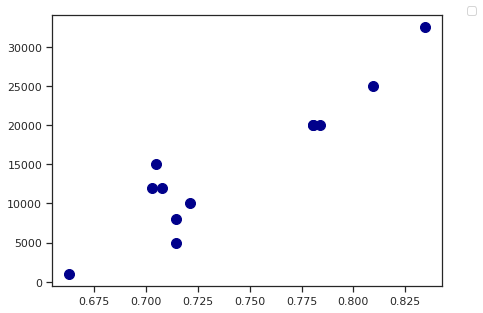

In [303]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()
ax.scatter(ex_df['metric.Accuracy'], ex_df['metric.Num_of_examples'], color='darkblue', s=100)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [316]:
ex_df['metric.Accuracy'].max()

0.8343098759651184

In [317]:
res = ex_df[ex_df['metric.Accuracy'] == ex_df['metric.Accuracy'].max()]

In [318]:
res

,experiment_name,run_name,param.Dataset Version,metric.Accuracy,metric.Loss,metric.Numeric_col,metric.Num_of_examples,metric.Categorical_col
11,earnings-classifier-ver1,tensorflow-dl-model-20210528130607,3.0,0.83431,0.351374,4.0,32561.0,3.0
